In [2]:
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision

     |████████████████████████████████| 2.0MB 9.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 6.2.2
    Uninstalling Pillow-6.2.2:
      Successfully uninstalled Pillow-6.2.2


IMPORTS

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
seed = 20
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

CONSTRUCTORS AND FUNCTIONS

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [0]:
def validate(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    
    return validation_loss

In [0]:
def validate_accuracy(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    return (str(100. * correct / len(loader.dataset))+"%")

MNIST LOADER

In [9]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 8343928.23it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 130364.96it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2140595.59it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 43777.84it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!




---





We can perform different types of initializations:


*   Zero initialization
*   Random initialization
*   Xavier/Glorot initialization
*   He initialization



In [0]:
def weights_init_zeros(m):
    if type(m) == nn.Linear:
        torch.nn.init.zeros_(m.weight)
        torch.nn.init.zeros_(m.bias)
    if type(m) == nn.Conv2d:
        torch.nn.init.zeros_(m.weight)
        torch.nn.init.zeros_(m.bias)
def weights_init_xavier_he(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)
    if type(m) == nn.Conv2d:
        torch.nn.init.kaiming_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

def weights_init_he_xavier(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

def weights_init_xavier_xavier(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

def weights_init_he(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)
    if type(m) == nn.Conv2d:
        torch.nn.init.kaiming_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

def weights_init_random(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight,mean = 0, std = 1)
        torch.nn.init.zeros_(m.bias)
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean = 0, std = 1)
        torch.nn.init.zeros_(m.bias)

In [0]:
initializations = [-1,weights_init_he,weights_init_he_xavier,weights_init_xavier_he,weights_init_xavier_xavier, weights_init_random,weights_init_zeros]
strings = ["Default init","Both He init", "Linear: He & Conv: Xavier", "Linear: Xavier & Conv: He" , "Both Xavier", "Random init (std=1)", "Initializing with zeros"]
final_accuracies = []
array_train_losses= []
array_valid_x= []
array_valid_losses = []
for init_function in initializations:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
  if init_function != -1:
    model.apply(init_function)
  train_losses = []
  valid_losses = []
  valid_x = []
  num_epochs = 10
  for epoch in range(1, num_epochs + 1):
      epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
      train_losses.extend(epoch_losses)
      valid_loss = validate(model, device, valid_loader)
      valid_losses.append([valid_loss])
      valid_x.append(len(train_losses) - 1)

  array_train_losses.append(train_losses)
  array_valid_x.append(valid_x)
  array_valid_losses.append(valid_losses)
  final_accuracies.append(validate_accuracy(model,device,valid_loader))
  #plt.gcf().clear()
  #plt.plot(train_losses, 'b-')
  #plt.plot(valid_x, valid_losses, 'r-')
  #plt.show()



---



---



Both the linear and convolutional (conv2d) layers are initialized in pytorch by default with the He (Kaiming) initialization:
```python
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
```
[Pytorch Linear Documentation](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py)

[Pytorch Conv2d Documentation](https://github.com/pytorch/pytorch/blob/029a968212b018192cb6fc64075e68db9985c86a/torch/nn/modules/conv.py#L49)



---
**PLOTTING EACH TRAINING AND VALIDATION CURVE FOR EVERY METHOD**


It's important to see the training process as it illustrates the convergence of each initialization.

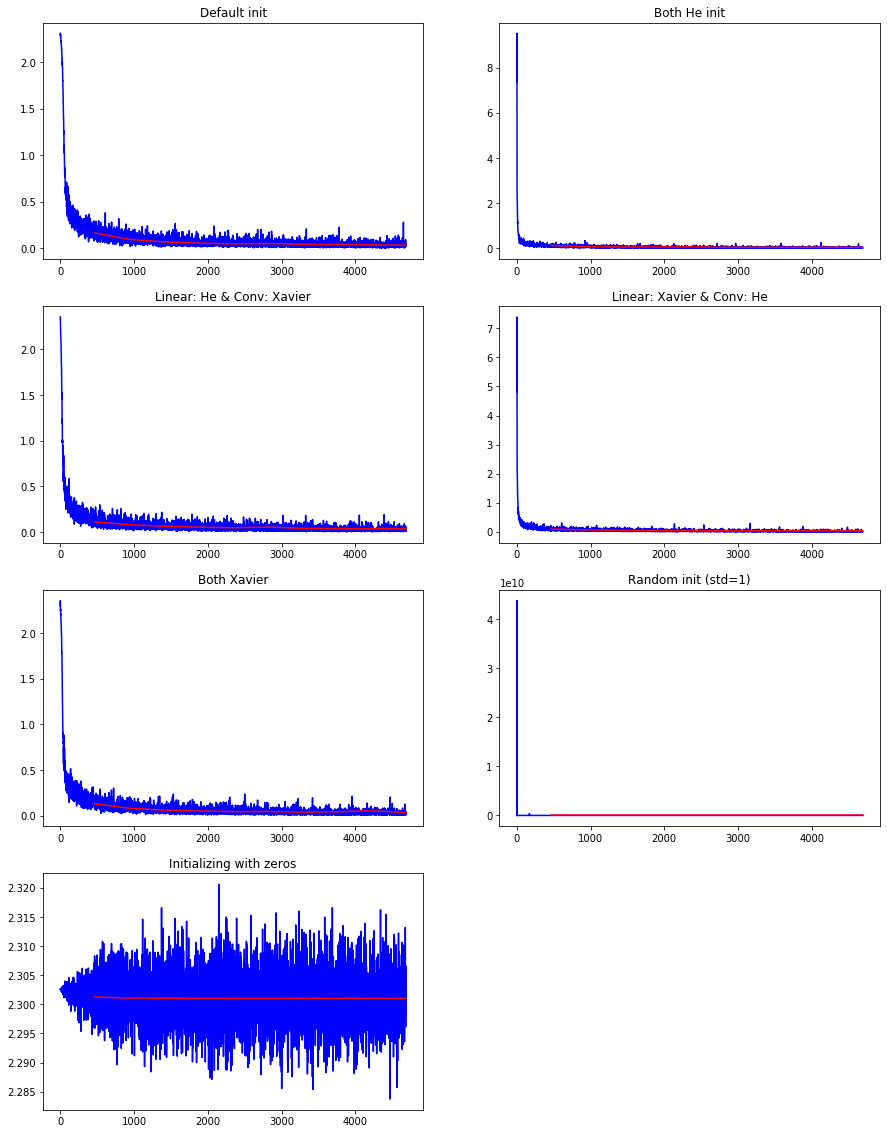

In [16]:
fig = plt.figure()

plt.subplot(4, 2, 1)
plt.title(strings[0])
plt.plot(array_train_losses[0], 'b-')
plt.plot(array_valid_x[0], array_valid_losses[0], 'r-')

plt.subplot(4, 2, 2)
plt.title(strings[1])
plt.plot(array_train_losses[1], 'b-')
plt.plot(array_valid_x[1], array_valid_losses[1], 'r-')

plt.subplot(4, 2, 3)
plt.title(strings[2])
plt.plot(array_train_losses[2], 'b-')
plt.plot(array_valid_x[2], array_valid_losses[2], 'r-')

plt.subplot(4, 2, 4)
plt.title(strings[3])
plt.plot(array_train_losses[3], 'b-')
plt.plot(array_valid_x[3], array_valid_losses[3], 'r-')

plt.subplot(4, 2, 5)
plt.title(strings[4])
plt.plot(array_train_losses[4], 'b-')
plt.plot(array_valid_x[4], array_valid_losses[4], 'r-')

plt.subplot(4, 2, 6)
plt.title(strings[5])
plt.plot(array_train_losses[5], 'b-')
plt.plot(array_valid_x[5], array_valid_losses[5], 'r-')

plt.subplot(4, 2, 7)
plt.title(strings[6])
plt.plot(array_train_losses[6], 'b-')
plt.plot(array_valid_x[6], array_valid_losses[6], 'r-')

fig.set_figheight(20)
fig.set_figwidth(15)
plt.show()

**PRINTING THE FINAL ACCURACIES FOR EACH WEIGHTING METHOD**

In [17]:
print("Final Accuracies for each method:\n\n")
for it in range(len(strings)):
  string = strings[it]+ " : "+final_accuracies[it]
  print(string+"\n")

Final Accuracies for each method:


Default init : 98.74%

Both He init : 98.75%

Linear: He & Conv: Xavier : 98.79%

Linear: Xavier & Conv: He : 98.73%

Both Xavier : 98.86%

Random init (std=1) : 11.35%

Initializing with zeros : 11.35%

